In [1]:
from QIP import *

In [32]:
def grovers(goal_state, num_iterations):
    num_qubits = len(goal_state)+1
    circuit = QCircuit(num_qubits,allow_empty_systems=True)
    
    # h on all except ancilla
    for qubit in range(num_qubits-1):
        circuit.h(qubit)
    # NOT on ancilla    
    circuit.x(num_qubits-1)
    # grover iteration
    for grover_iteration in range(num_iterations):
        # flip ancilla controlled by bitstring of goal state
        circuit.apply_to_circuit(arbitrary_U(x,num_qubits,[num_qubits-1],control_bitstring=goal_state))
        
        # h on all except ancilla
        for qubit in range(num_qubits-1):
            circuit.h(qubit)

        # phase flip ancilla if state is all zeros
        circuit.apply_to_circuit(arbitrary_U(z,num_qubits,[num_qubits-1],control_bitstring='0'*len(goal_state)))

        # h on all except ancilla
        for qubit in range(num_qubits-1):
            circuit.h(qubit)
    return circuit

Grover's algorithm on $4+1$ qubits

In [33]:
grovers_circuit_4_bits = grovers('1101',int(np.ceil(np.pi*np.sqrt(2**4)/4)))

In [4]:
bitstrings_dict_from_vector(grovers_circuit_4_bits.statevector)

{'00001': -0.0072631835937500035,
 '00010': -2.1919876711817086e-34,
 '00011': -0.007263183593750047,
 '00101': -0.007263183593750078,
 '00110': 5.613085483468041e-51,
 '00111': -0.00726318359375001,
 '01001': -0.007263183593750086,
 '01010': 2.6546939246402185e-17,
 '01011': -0.007263183593750074,
 '01101': -0.007263183593750051,
 '01110': 5.834417937946716e-34,
 '01111': -0.007263183593750011,
 '10001': -0.0072631835937501015,
 '10010': 2.2018009957201892e-17,
 '10011': -0.007263183593749945,
 '10101': -0.0072631835937500226,
 '10110': -9.6979166554522e-34,
 '10111': -0.007263183593750035,
 '11001': -0.00726318359375,
 '11010': -0.7104492187500011,
 '11011': 0.7031860351562513,
 '11101': -0.007263183593750085,
 '11110': 2.654693924640218e-17,
 '11111': -0.007263183593749955}

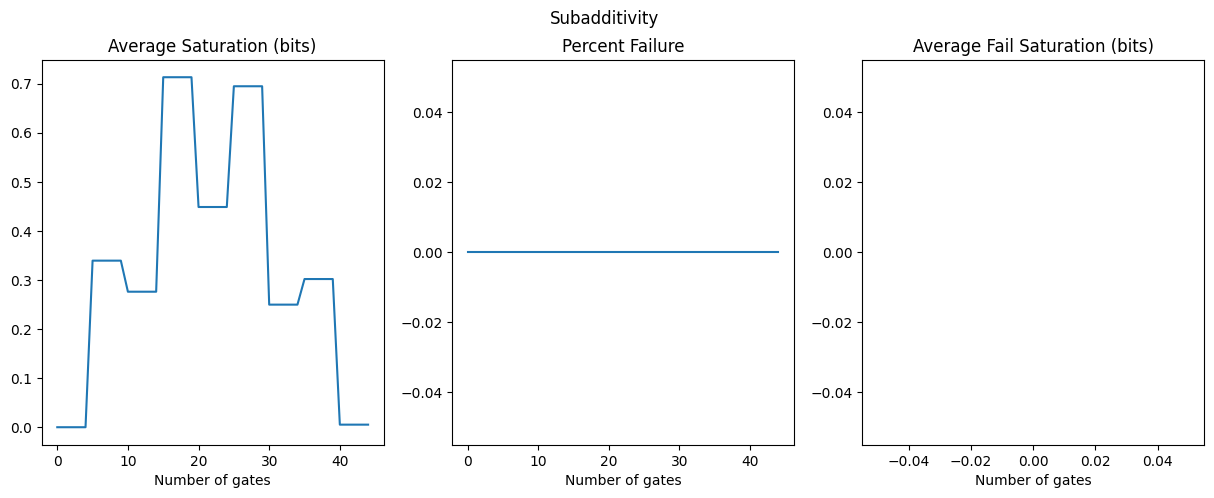

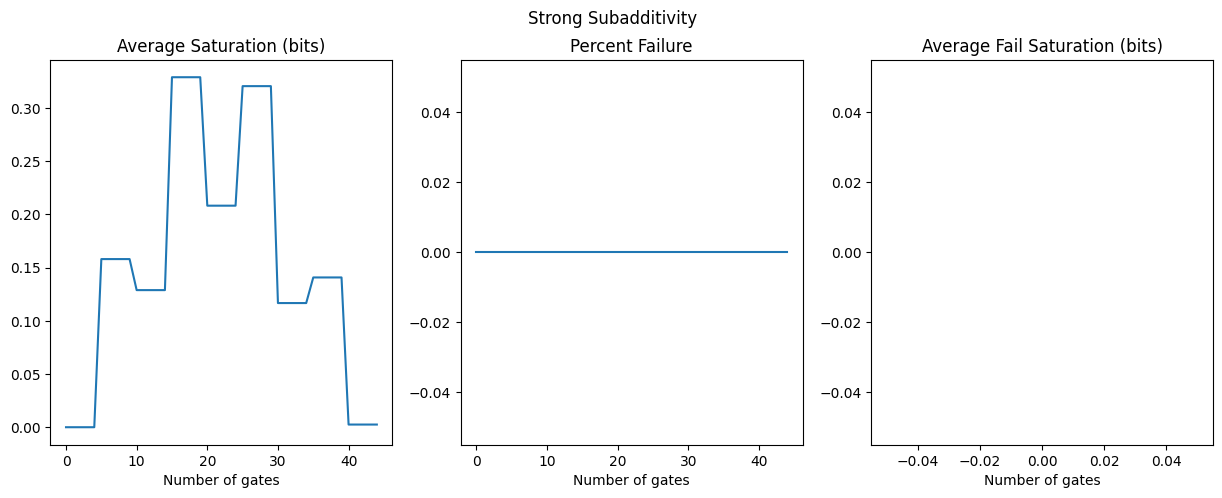

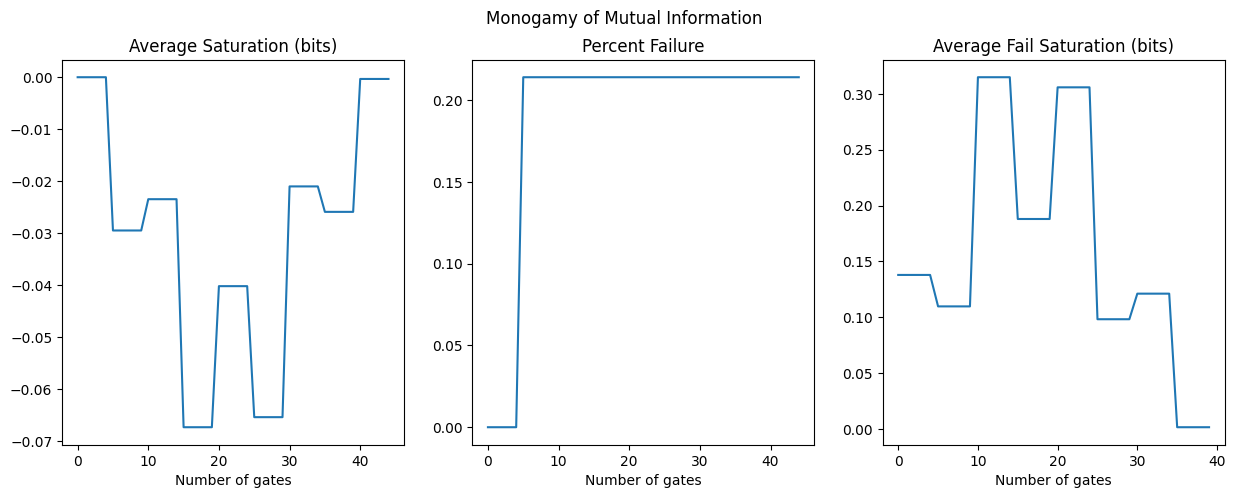

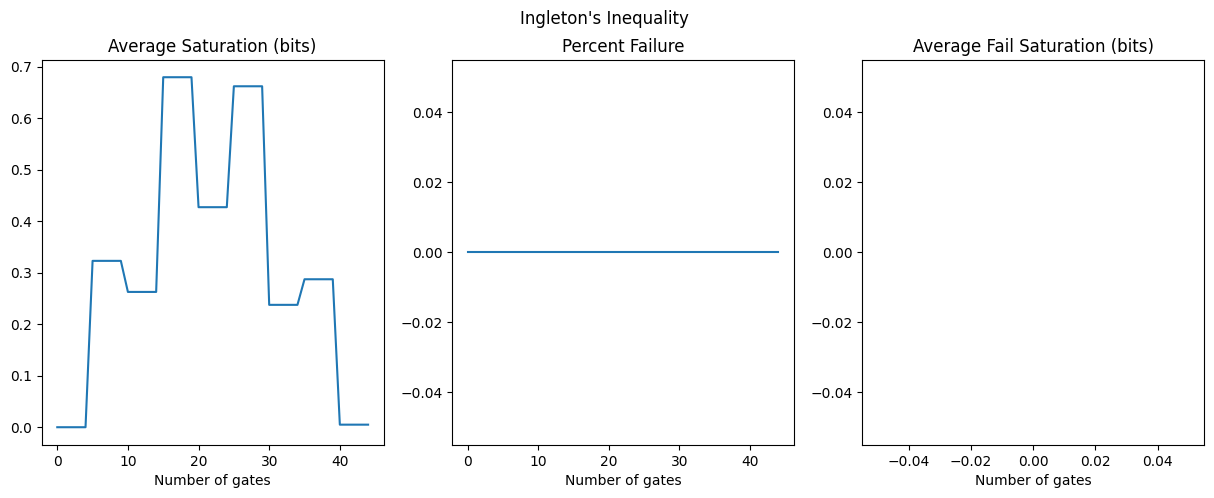

In [34]:
grovers_circuit_4_bits.plot_saturations(savefiles=True,folder="grovers-4/")

Grover's algorithm on 5 qubits

In [35]:
grovers_circuit_5_bits = grovers('11010',int(2**4))

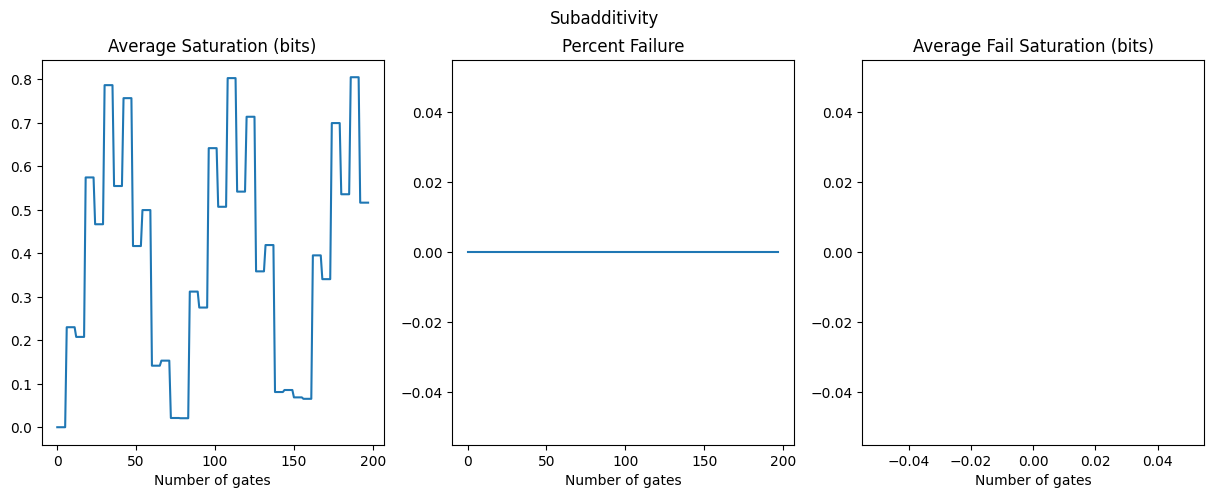

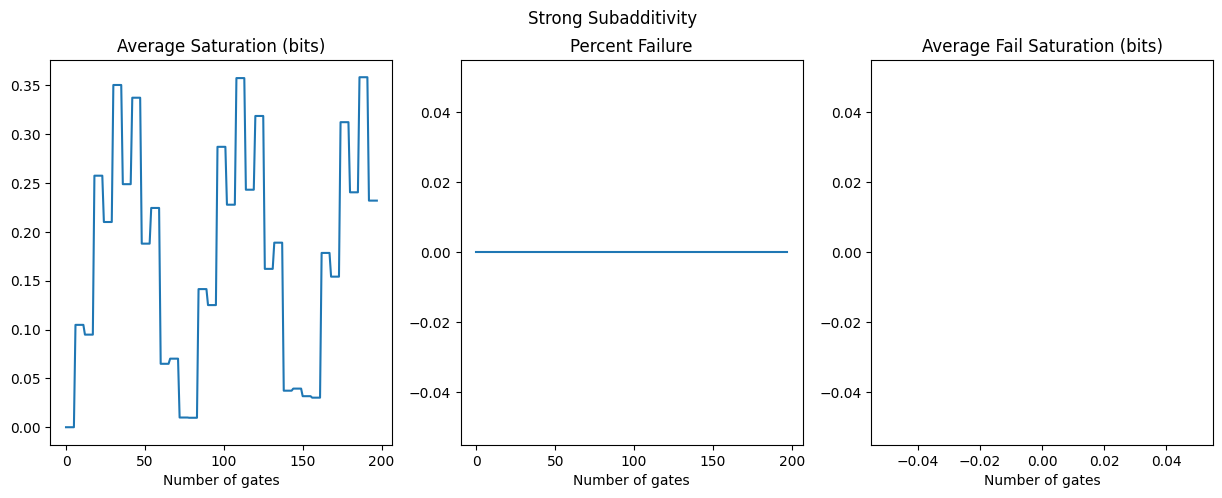

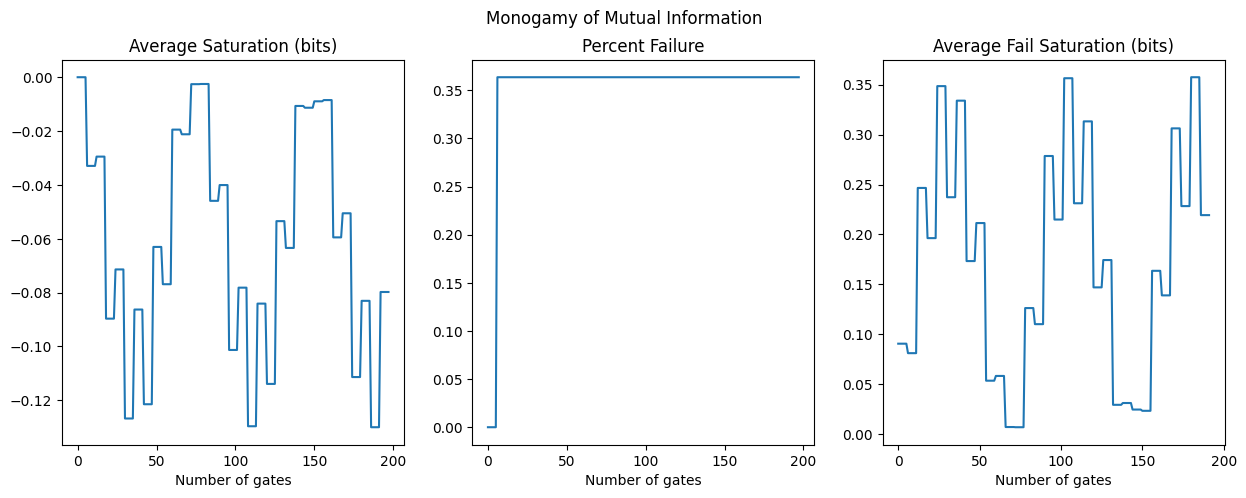

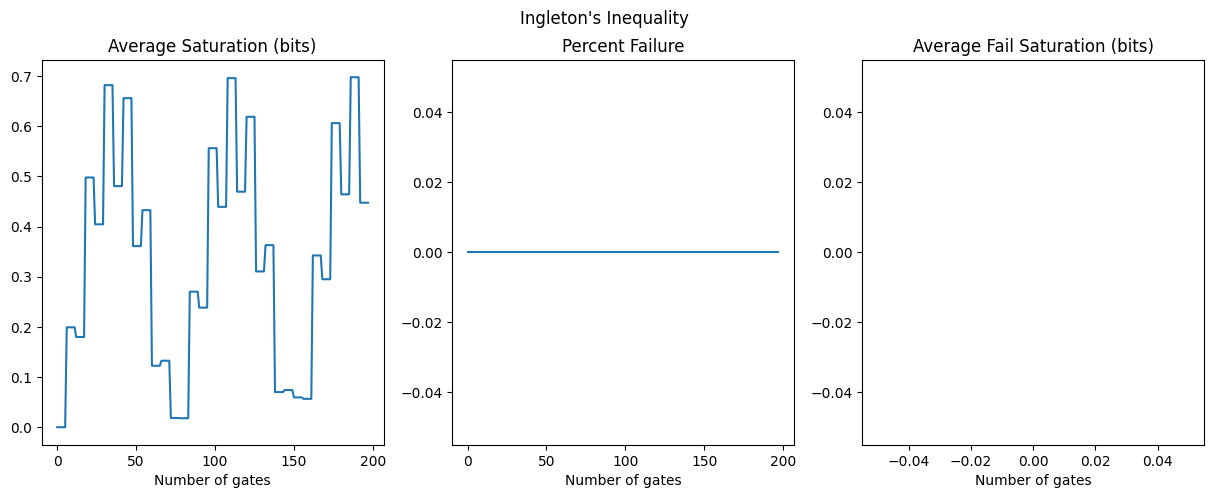

In [7]:

grovers_circuit_5_bits.plot_saturations(savefiles=True,folder="grovers-5/")


Grover's algorithm on 6 qubits

In [8]:
grovers_circuit_6_bits = grovers('110101',int(2**4))


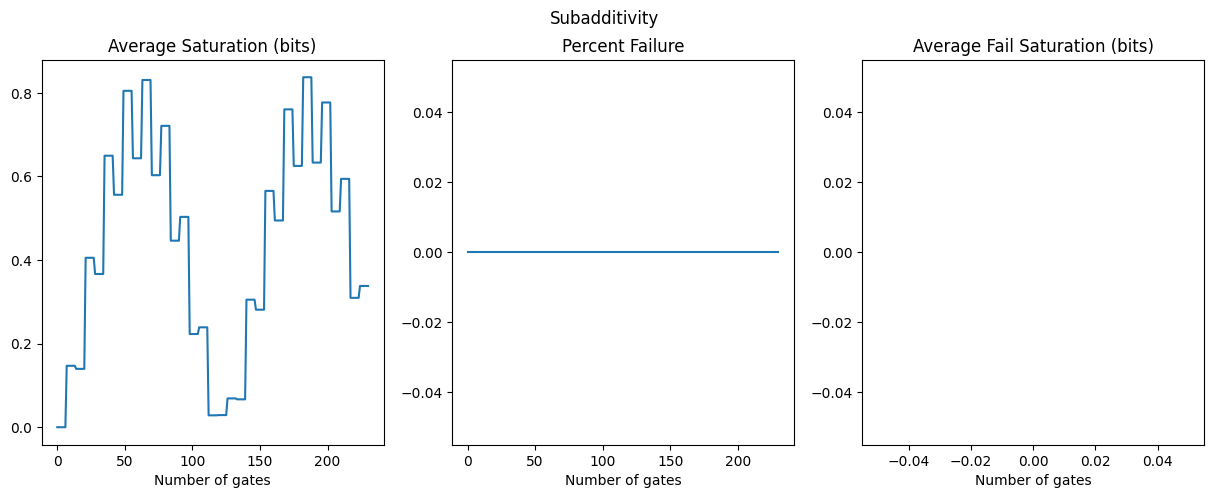

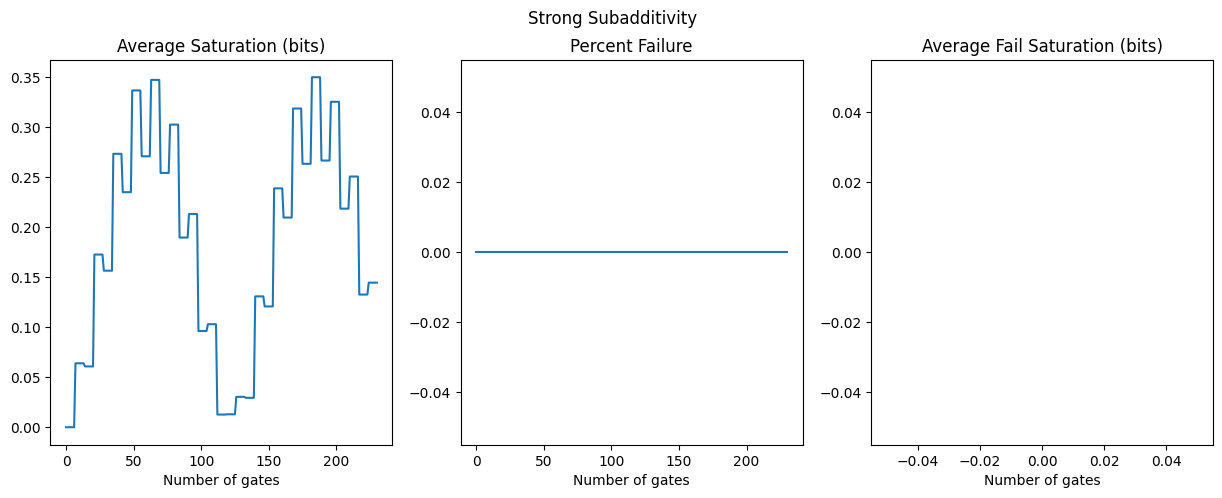

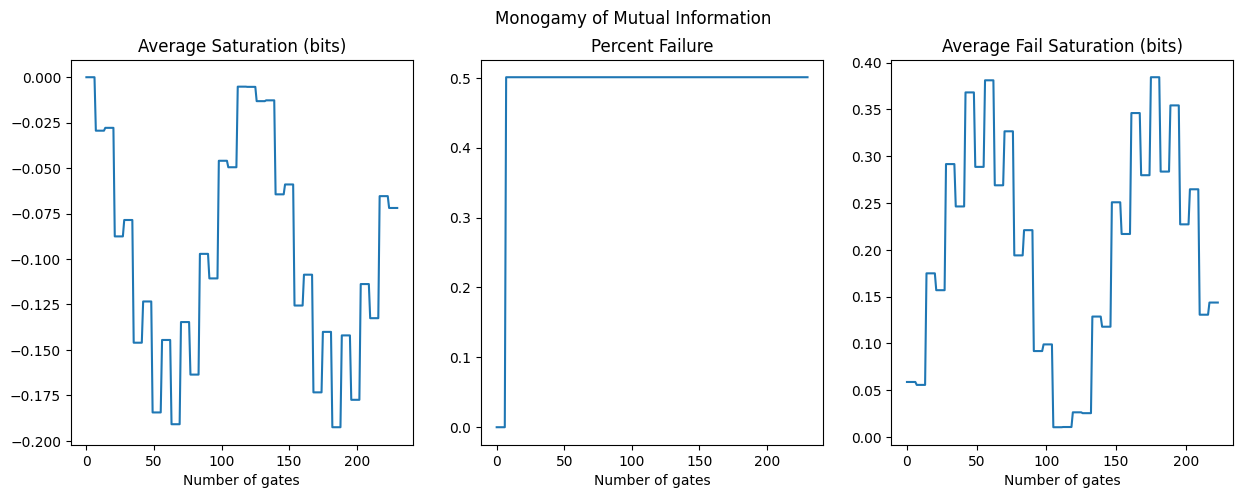

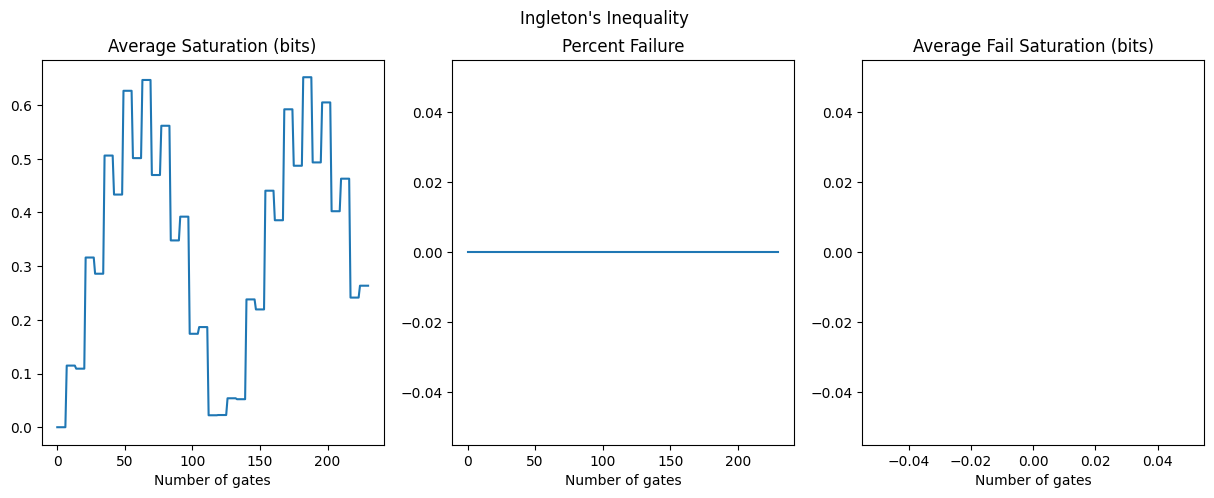

In [9]:
grovers_circuit_6_bits.plot_saturations(savefiles=True,folder="grovers-6/")

In [10]:
def qft(circuit_size,input_vector=None):
        
    if input_vector is not None:
        circuit = QCircuit(circuit_size,initial_state=input_vector)
    else: circuit = QCircuit(circuit_size)
    # Begin the QFT
    for i in range(circuit_size):
        circuit.h(i)
        
        for k in range(2,circuit_size+1-i):
            R_k = np.array([[1.,0.],[0.,np.exp(1.j*2*np.pi/2**k)]])
            circuit.apply_to_circuit(arbitrary_U(R_k,circuit_size,[i],controls=[i+k-1]))
    circuit.reverse_bits()
    return circuit

Interesting note: The DFT matrix using $\omega=e^{2\pi i/8}=\sqrt{i}$ as in Nielsen and Chuang will give the fourier transform but in the wrong order, but using $e^{-2\pi i/8}$ gives the correct order, however this is not what the QFT does. One would need to do a swap operation reversing the second to the last elements in the statevector.

In [11]:
vec=np.random.random(2**3)+np.random.random(2**3)*1j
vec=vec/np.linalg.norm(vec)

k = np.arange(8)
W_plus = np.exp(2j * np.pi * k[:, None] * k / 8)/8**.5
W_minus = np.exp(-2j * np.pi * k[:, None] * k / 8)/8**.5
fft = np.round(np.fft.fft(vec)/8**.5,4)
qftc=np.round(qft(3,vec).statevector,4)
print("x: \t\t\t"+"DFT+(x): \t\t"+"DFT-(x): \t\t"+ "FFT(x): \t\t","QFT(x): ")
for i in range(8):
    print(np.round(vec[i],4),"\t",np.round((W_plus@vec)[i],4),"\t",np.round((W_minus@vec)[i],4),"\t",fft[i],"\t",qftc[i])

x: 			DFT+(x): 		DFT-(x): 		FFT(x): 		 QFT(x): 
(0.285+0.027j) 	 (0.6124+0.5639j) 	 (0.6124+0.5639j) 	 (0.6124+0.5639j) 	 (0.6124+0.5639j)
(0.112+0.0963j) 	 (0.1092-0.0363j) 	 (-0.1152-0.0473j) 	 (-0.1152-0.0473j) 	 (0.1092-0.0363j)
(0.2487+0.2497j) 	 (0.2317-0.1049j) 	 (0.0782+0.0291j) 	 (0.0782+0.0291j) 	 (0.2317-0.1049j)
(0.1153+0.0182j) 	 (-0.0132-0.3842j) 	 (-0.1755-0.0727j) 	 (-0.1755-0.0727j) 	 (-0.0132-0.3842j)
(0.4226+0.4091j) 	 (0.0784+0.1286j) 	 (0.0784+0.1286j) 	 (0.0784+0.1286j) 	 (0.0784+0.1286j)
(0.1709+0.103j) 	 (-0.1755-0.0727j) 	 (-0.0132-0.3842j) 	 (-0.0132-0.3842j) 	 (-0.1755-0.0727j)
(0.0207+0.2936j) 	 (0.0782+0.0291j) 	 (0.2317-0.1049j) 	 (0.2317-0.1049j) 	 (0.0782+0.0291j)
(0.3569+0.3982j) 	 (-0.1152-0.0473j) 	 (0.1092-0.0363j) 	 (0.1092-0.0363j) 	 (-0.1152-0.0473j)


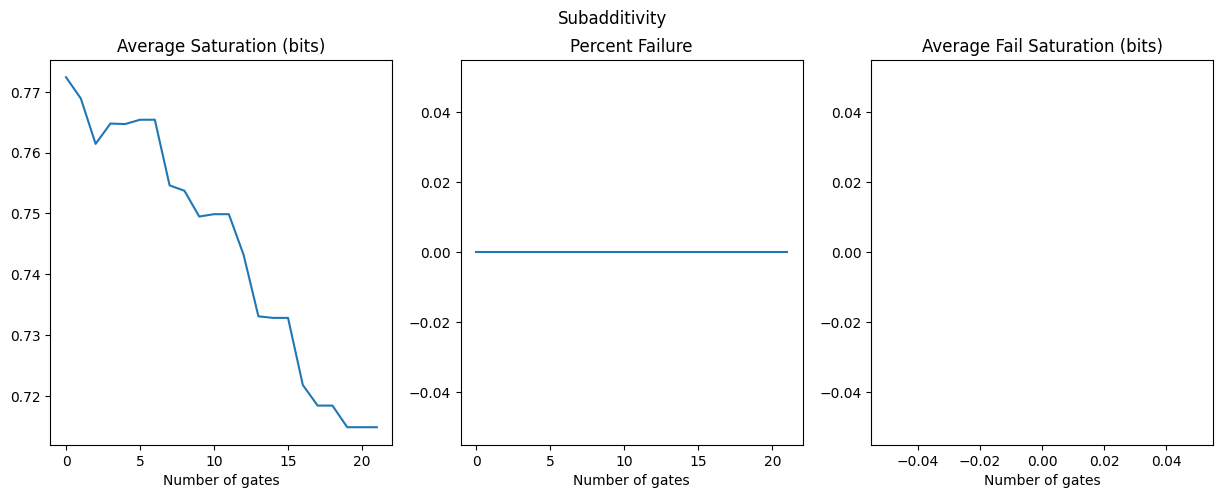

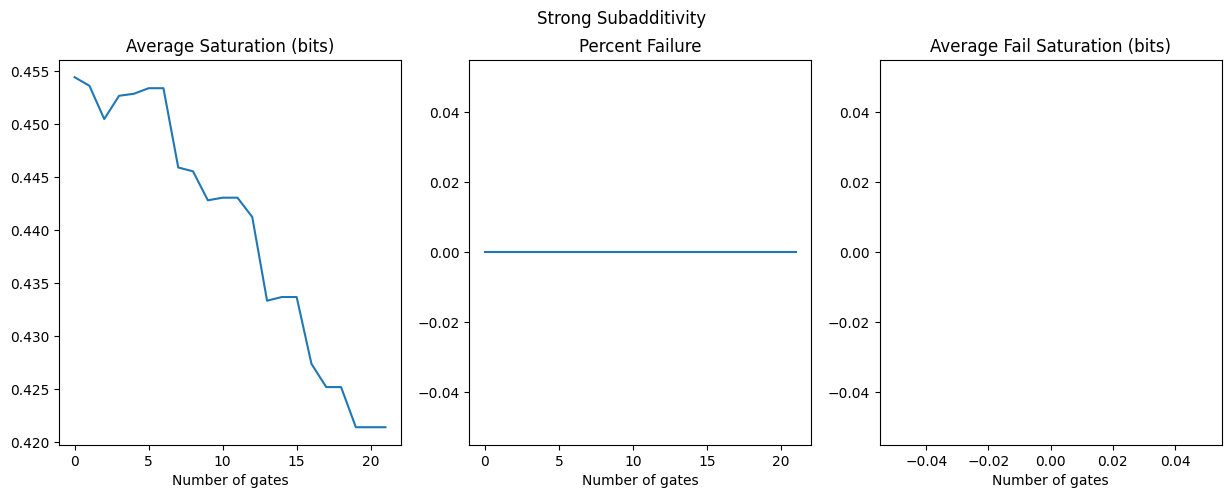

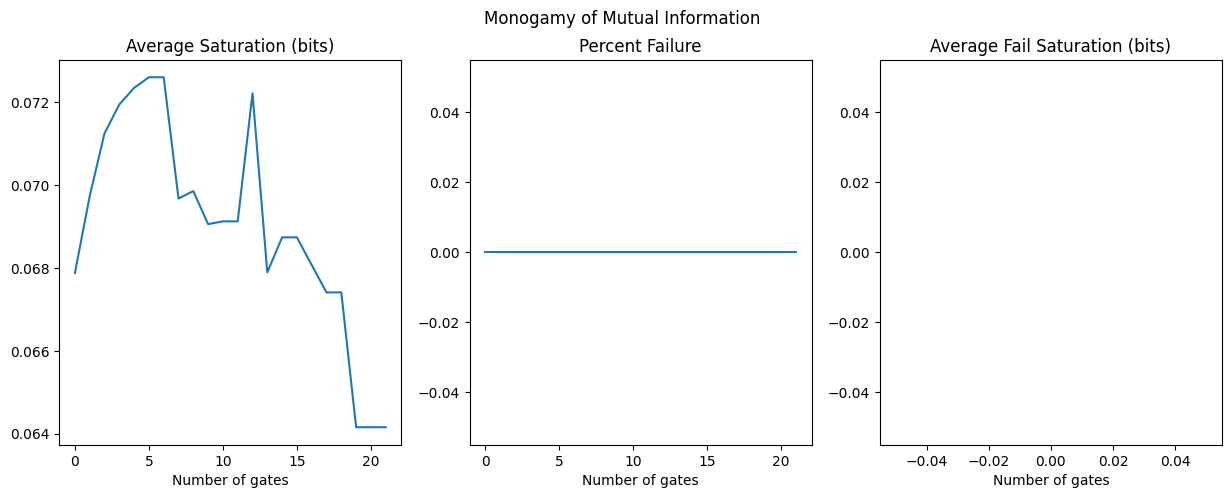

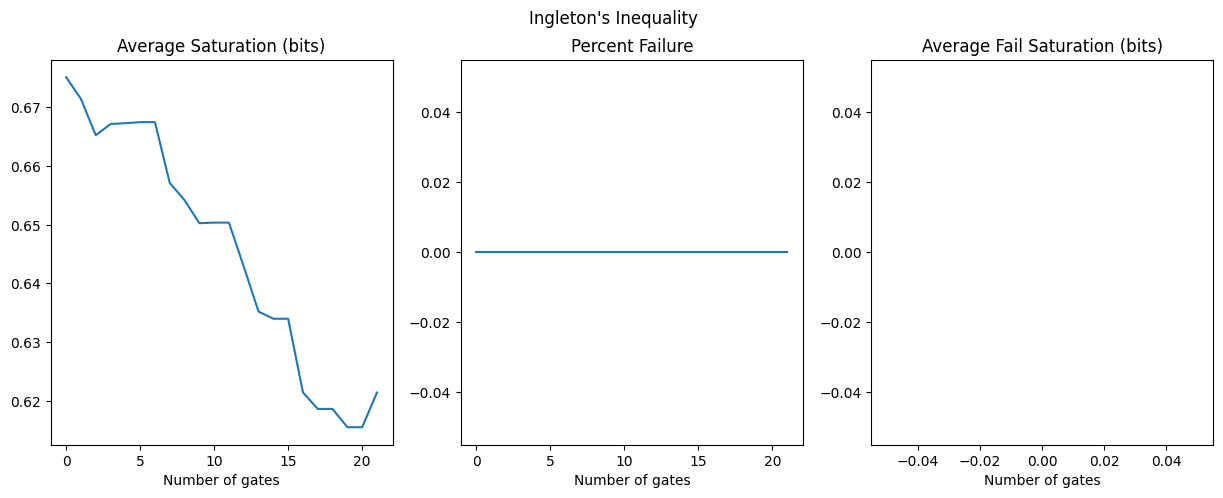

In [40]:
vec=np.random.random(2**6)+np.random.random(2**6)*1j
vec=vec/np.linalg.norm(vec)
qft_circuit = qft(6,vec)
qft_circuit.plot_saturations(savefiles=True,folder="qft-6/")

In [19]:
def qft_inverse(circuit_size,input_vector = None):
    if input_vector is not None:
        circuit = QCircuit(circuit_size,initial_state=input_vector)
    else: circuit = QCircuit(circuit_size)
    
    # Begin the inverse QFT
    
    # Hadamard on every qubit
    for i in range(circuit_size):
        circuit.h(i)
        
        # Controlled reverse-phase on each qubit 
        for k in range(2,circuit_size-i+1):
            R_k = np.array([[1.,0.],[0.,np.exp(-1.j*2*np.pi/2**k)]])
            circuit.apply_to_circuit(arbitrary_U(R_k,circuit_size,targets=[i],controls=[i+k-1]))
    circuit.reverse_bits()

    return circuit

In [20]:
qft_i_circuit_6 = qft_inverse(6,vec)

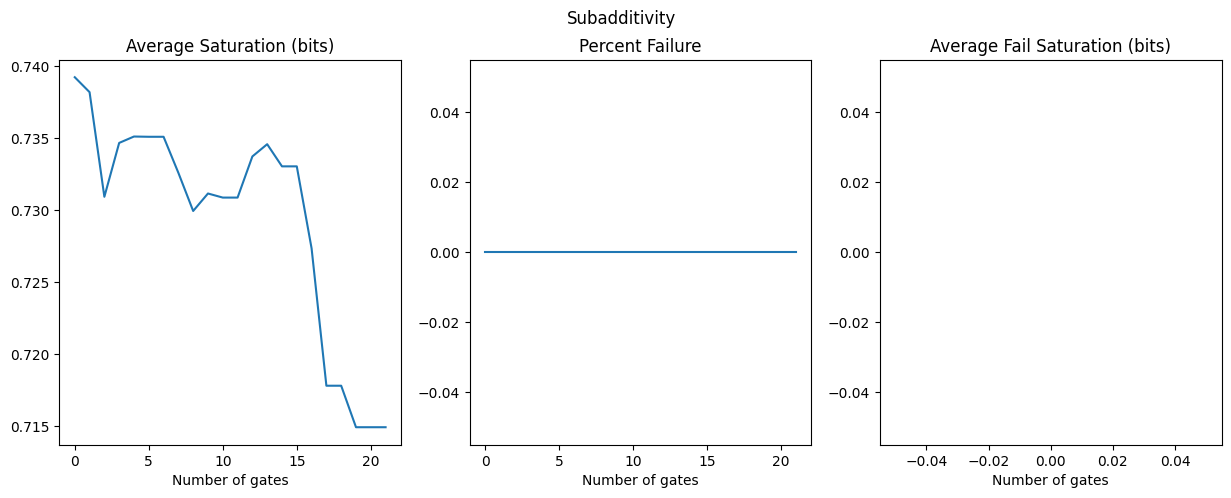

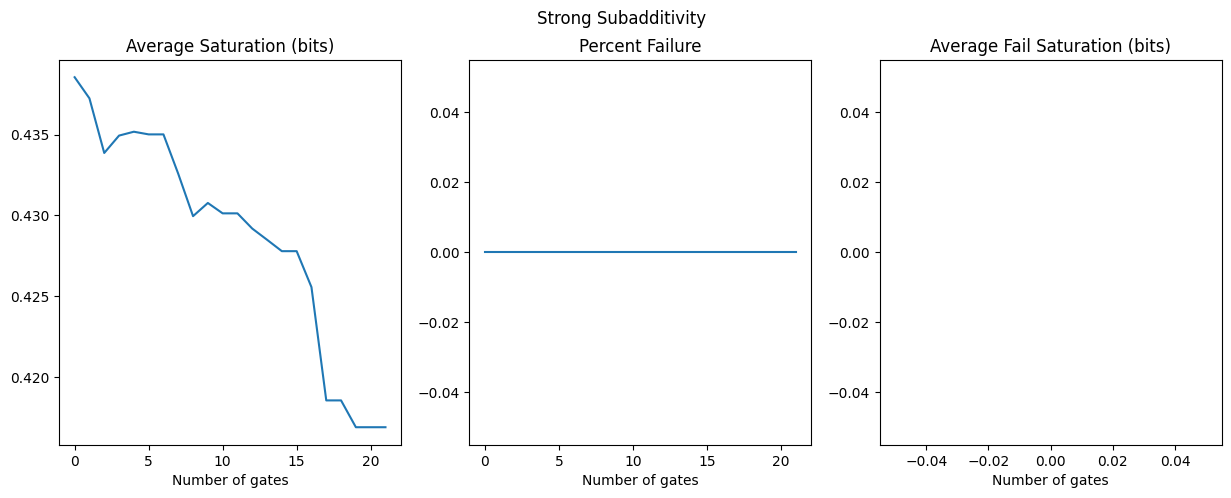

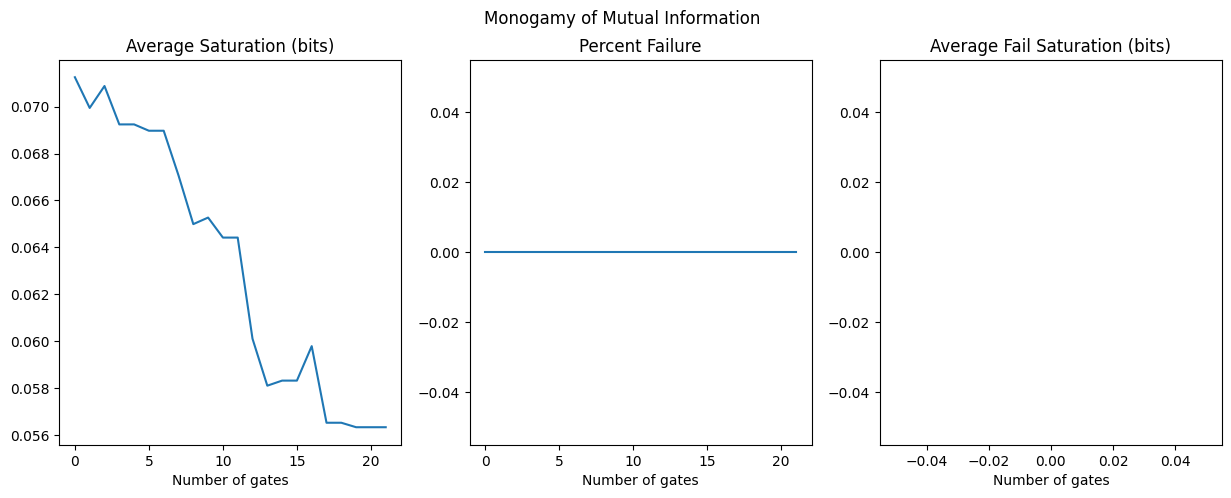

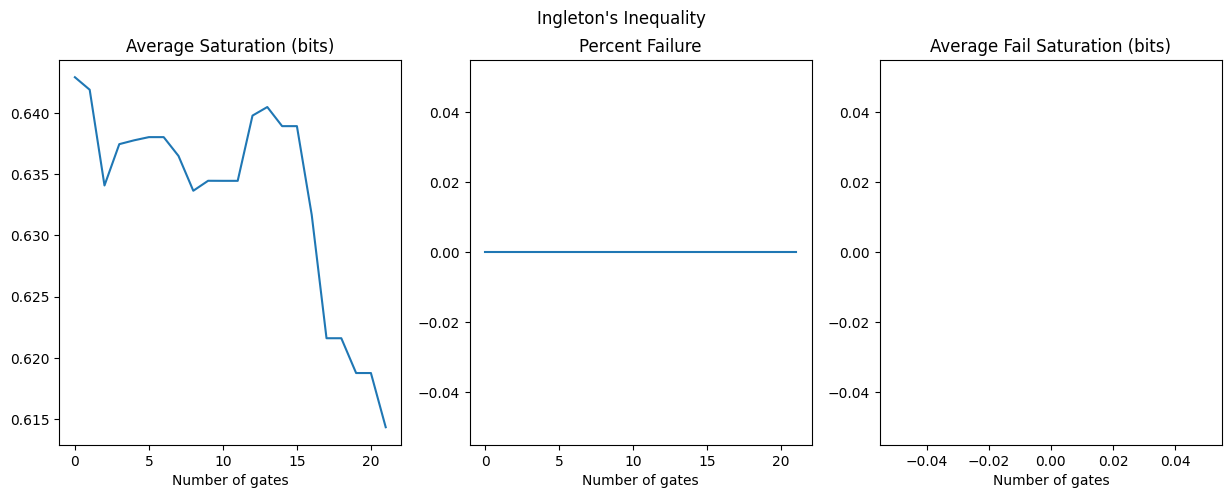

In [21]:
qft_i_circuit_6.plot_saturations(savefiles=True,folder="qft-i-6/")

In [22]:
def qpe(U,num_auxiliary_bits,eigvec):
    
    m = int(np.log2(np.shape(U)[0]))
    num_qubits = num_auxiliary_bits + m
    circuit = QCircuit(num_qubits,initial_state=np.kron(bitstrings_to_vector('0'*num_auxiliary_bits),eigvec),pure_state=False)
    for i in range(num_auxiliary_bits):
        circuit.h(i)
    for k in range(num_auxiliary_bits):
        circuit.apply_to_circuit(arbitrary_U(U**(2**k),num_qubits,list(range(num_auxiliary_bits,num_qubits)),controls=[num_qubits-m-1-k]))
    qfti_circuit = qft_inverse(num_auxiliary_bits)
    #qfti_circuit.reverse_bits()
    circuit.apply_to_circuit(arbitrary_U(qfti_circuit.unitary,num_qubits,list(range(num_auxiliary_bits))))
    return circuit

In [24]:
def qr_haar(N):
    """Generate a Haar-random matrix using the QR decomposition."""
    # Step 1
    A, B = np.random.normal(size=(N, N)), np.random.normal(size=(N, N))
    Z = A + 1j * B

    # Step 2
    Q, R = np.linalg.qr(Z)

    # Step 3
    Lambda = np.diag([R[i, i] / np.abs(R[i, i]) for i in range(N)])

    # Step 4
    return np.dot(Q, Lambda)

In [25]:
U_size = 4
rand_U = qr_haar(U_size)
eigvals, eigvecs = np.linalg.eig(rand_U)
eigval = eigvals[0]
qpe_circuit = qpe(rand_U,3,eigvecs[:,0])

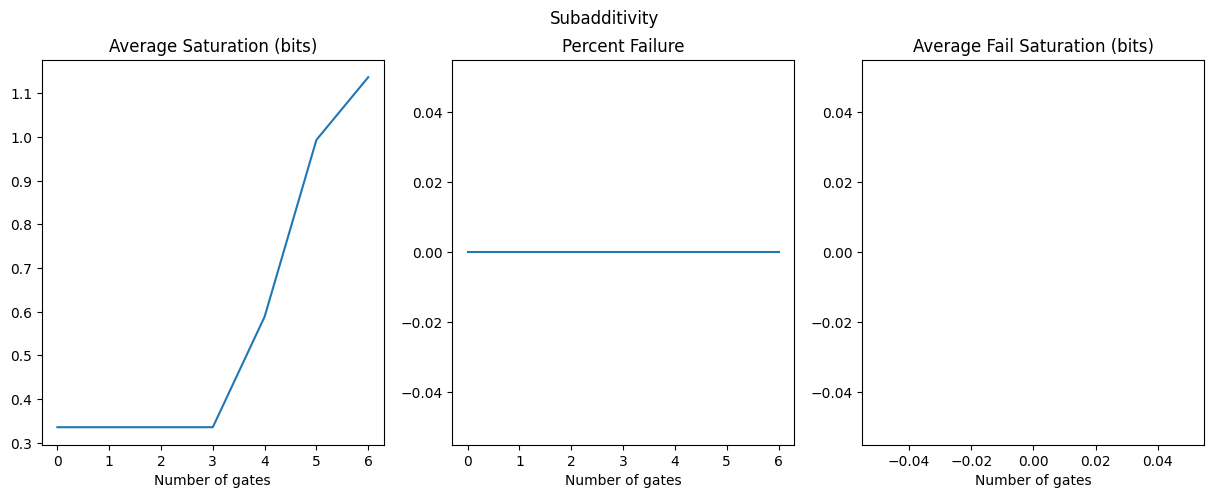

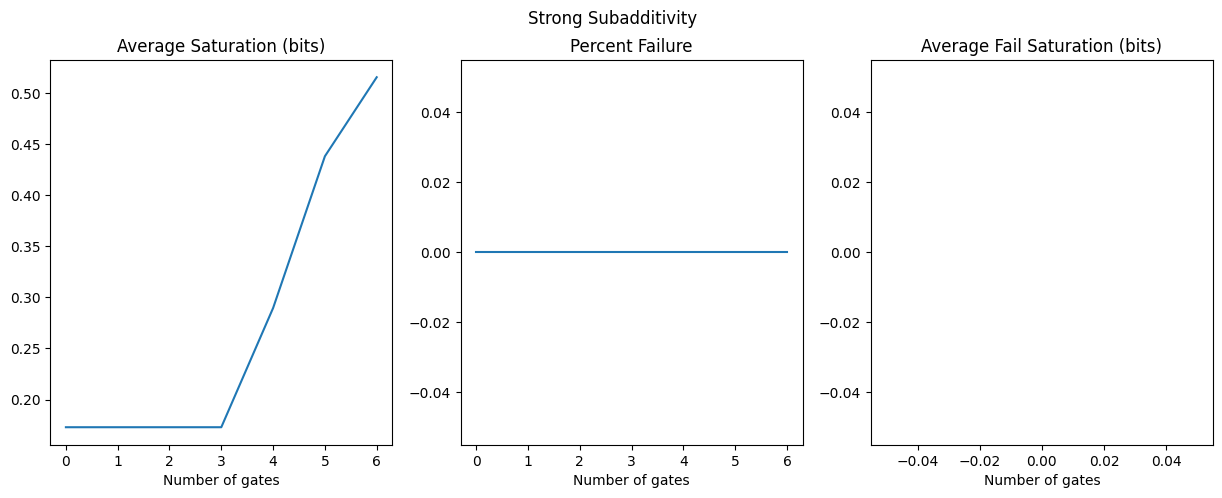

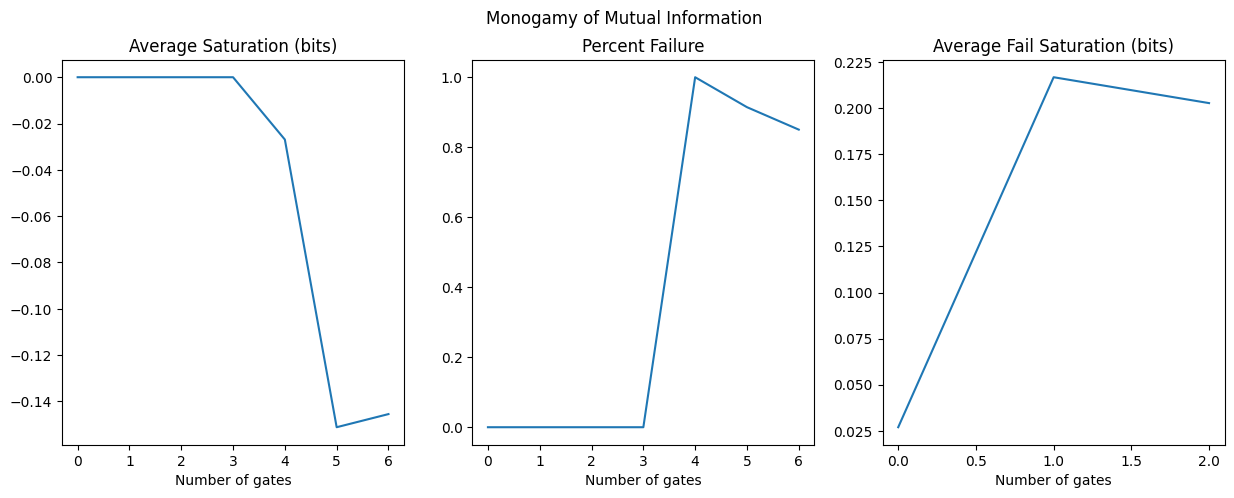

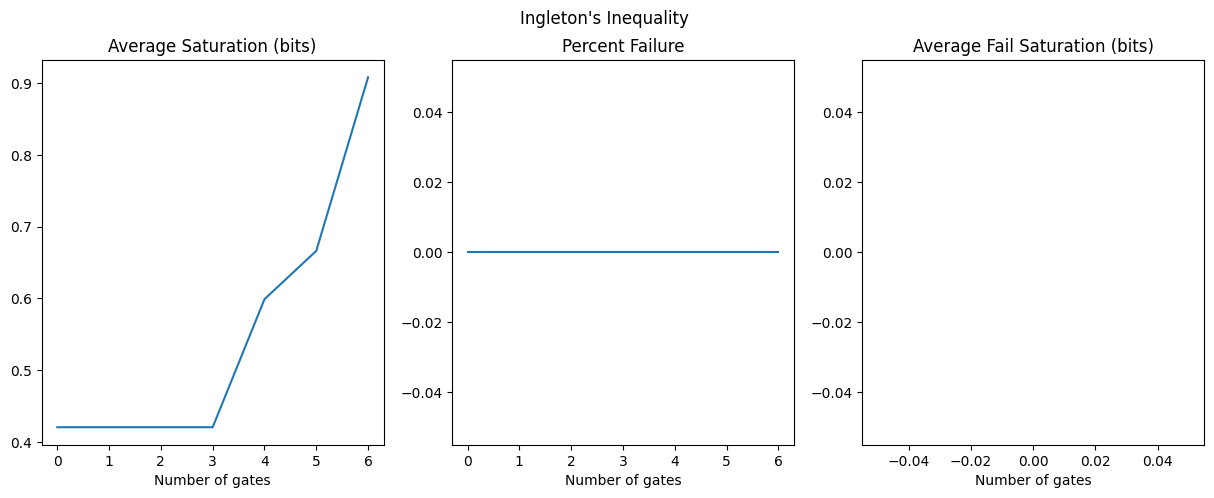

In [27]:

qpe_circuit.plot_saturations(savefiles=True,folder="qpe-7/")

Shor's

In [9]:
#Here we build the unitary needed for Shor's. In each step of phase estimation we must construct a new one
def order_finding_U(a,n,N):
    U = np.zeros((2**n,2**n))
    for k in range(2**n):
        if k < N: 
            transformed_k = (a*k)%N
        else: transformed_k = k
        row = np.array(1.)
        for bit in int_to_bitstring(transformed_k,n):
            row = np.kron(row,qubit_map[bit])
        U[k]=row
    return U.T

def order_finding(a,N):
    
    # number of qubits in second register
    n = int(np.ceil(np.log2(N)))
    
    # accuracy and number of qubits in first register
    m = 2*n+1
    
    # now execute the circuit
    circuit = QCircuit(m+n)
    
    # phase estimation step 
    
    # second register starts as |1>
    for q in range(m,n+m):
        circuit.x(q)
    
    # hadamard on all inputs
    for q in range(m):
        circuit.h(q)
    
    # controlled unitaries
    for k in range(m):
        circuit.apply_to_circuit(arbitrary_U(order_finding_U(a**(2**k),n,N),n+m,list(range(m,n+m)),controls=[n-1-k]))
    
    # inverse qft
    qfti_circuit = qft_inverse(m)
    circuit.apply_to_circuit(arbitrary_U(qfti_circuit.unitary,n+m,list(range(m))))
    return circuit
    
    
    

    

In [7]:

# my method for the partial trace, reorder the density matrix such that the bits to be traced out are at the end, then trace over second partition

def reorder_U(circuit_size,bits):
    """_summary_

    Args:
        circuit_size (int): number of bits in circuit
        bits (list): bits to move to the end

    Returns:
        ndarray: unitary permutation matrix which reorders the given bits
    """
    lgm = np.zeros((2**circuit_size,2**circuit_size))
    for bitint in range(2**circuit_size):
        bitstring = int_to_bitstring(bitint,circuit_size)
        transformed_bitstring = [bitstring[i] for i in range(len(bitstring)) if i not in bits] + [bitstring[i] for i in bits]
        row = np.array(1.)
        for bit in transformed_bitstring:
            row = np.kron(row,qubit_map[bit])
        lgm[bitint]=row
    return lgm.T

def partial_trace2(p,trace_out):
    """finds the reduced density matrix after tracing out the given indices

    Args:
        p (numpy.ndarray (2-d)): full density matrix
        trace_out (list): indices to trace out
    """
    d_b = len(trace_out)
    d_a = int(np.log2(np.shape(p)[0])) - d_b
    sum = 0
    for j in range(2**d_b):
        vec = np.zeros(2**d_b)
        vec[j]=1.
        vec.shape=(2**d_b,1)
        sum = sum + np.kron(np.eye(2**d_a),vec.conj().T)@reorder_U(d_b+d_a,trace_out).conj().T@p@reorder_U(d_b+d_a,trace_out)@np.kron(np.eye(2**d_a),vec)
        # sum = sum + np.kron(np.eye(2**d_a),vec.conj().T)@p@np.kron(np.eye(2**d_a),vec)
    return sum


In [5]:
def reorder_U(circuit_size,bits):
    """_summary_

    Args:
        circuit_size (int): number of bits in circuit
        bits (list): bits to move to the end

    Returns:
        ndarray: unitary permutation matrix which reorders the given bits
    """
    lgm = np.zeros((2**circuit_size,2**circuit_size))
    for bitint in range(2**circuit_size):
        bitstring = int_to_bitstring(bitint,circuit_size)
        transformed_bitstring = [bitstring[i] for i in bits] + [bitstring[i] for i in range(len(bitstring)) if i not in bits]
        row = np.array(1.)
        for bit in transformed_bitstring:
            row = np.kron(row,qubit_map[bit])
        lgm[bitint]=row
    return lgm.T

In [3]:
checkOperator(arbitrary_U(x,4,[3],controls=[0]))

0000 -> 0000
0001 -> 0001
0010 -> 0010
0011 -> 0011
0100 -> 0100
0101 -> 0101
0110 -> 0110
0111 -> 0111
1000 -> 1001
1001 -> 1000
1010 -> 1011
1011 -> 1010
1100 -> 1101
1101 -> 1100
1110 -> 1111
1111 -> 1110


In [27]:
# a better method, turn the indices into bitstrings and sum over the bits given
def partial_trace(p,trace_out):
    """ finds the reduced density matrix given indices of bits to trace over

    Args:
        p (ndarray): density matrix to reduce
        trace_out (list): indices of bits to trace over

    Returns:
        ndarray: reduced density matrix after tracing out the given bits
    """
    d_b = len(trace_out)
    d_a = int(np.log2(np.shape(p)[0])) - d_b
    p_A = np.zeros((2**d_a,2**d_a),dtype=complex)
    for i in range(2**d_a):
        for k in range(2**d_a):
            for j in range(2**d_b):
                # build the bitstring of the indices, summing over only j
                bra_bitstring = ""
                ket_bitstring = ""
                ik_c = 0 # keep track of which binary digit of i,k 
                j_c = 0 # keep track of which binary digit of j, summed over
                for l in range(d_b+d_a):
                    if l in trace_out:
                        bra_bitstring = bra_bitstring + int_to_bitstring(j,d_b)[j_c]
                        ket_bitstring = ket_bitstring + int_to_bitstring(j,d_b)[j_c]
                        j_c = j_c + 1
                    else:
                        bra_bitstring = bra_bitstring + int_to_bitstring(i,d_a)[ik_c]
                        ket_bitstring = ket_bitstring + int_to_bitstring(k,d_a)[ik_c]
                        ik_c = ik_c + 1
                p_A[i][k] = p_A[i][k]+ p[int(bra_bitstring,2)][int(ket_bitstring,2)]
                # equivalent 'mathy' way but slower:
                # bra = bitstrings_to_vector(bra_bitstring)
                # bra.shape=(2**(d_b+d_a),1)
                # bra = bra.conj().T
                # ket = bitstrings_to_vector(ket_bitstring)
                # ket.shape=(2**(d_b+d_a),1)
                # p_A[i][k] = p_A[i][k]+bra@p@ket
    return p_A


In [41]:
partial_trace(U,[0])

array([[-0.07947533+0.01740418j,  0.24859421+0.27760346j,
        -0.51507764+0.05932707j, -0.53367758+0.55245856j],
       [ 0.66564568-0.53525363j, -0.25771319-0.08386336j,
         0.57770121-0.45927752j,  0.63226509+0.75214147j],
       [ 0.47813061-0.0157401j ,  0.49271198+0.06545887j,
        -0.38056547+0.46541328j, -0.5375601 +0.00085667j],
       [-0.09370206+0.26815878j, -0.22654193+0.37509979j,
        -0.07399897-0.22547028j,  0.01855772+0.13406338j]])

In [42]:

partial_trace2(U,[0])

array([[-0.07947533+0.01740418j,  0.24859421+0.27760346j,
        -0.51507764+0.05932707j, -0.53367758+0.55245856j],
       [ 0.66564568-0.53525363j, -0.25771319-0.08386336j,
         0.57770121-0.45927752j,  0.63226509+0.75214147j],
       [ 0.47813061-0.0157401j ,  0.49271198+0.06545887j,
        -0.38056547+0.46541328j, -0.5375601 +0.00085667j],
       [-0.09370206+0.26815878j, -0.22654193+0.37509979j,
        -0.07399897-0.22547028j,  0.01855772+0.13406338j]])

In [11]:
s=time.time()
partial_trace(matrix,[1,3])
e=time.time()
print(e-s)

0.0015652179718017578


In [48]:
from QIP import *
n=6
W_state_dict = {}
for i in range(n):
    bitstring = "0"*n
    bitstring = bitstring[:i] + '1' + bitstring[i+1:]
    W_state_dict[bitstring] = 1/n**.5
W_state = QCircuit(6,initial_state=bitstrings_to_vector(W_state_dict))
W_state.subsysem_analysis()
print("W state: "+state_as_string(W_state_dict))
# prints an empty list if ingletons never fails
print("Average failure saturation of ingletons inequality: "+str(W_state.ing["avg_fail_saturation"]))

W state: 0.408|100000> + 0.408|010000> + 0.408|001000> + 0.408|000100> + 0.408|000010> + 0.408|000001>
Saturation of ingletons inequality: []


In [50]:
state_dict = {}
state_dict['0000']=1/4
state_dict['1111']=1/4
state_dict['1010']=1/4
state_dict['1001']=1/4
ing_test = QCircuit(4,initial_state=bitstrings_to_vector(state_dict))
ing_test.subsysem_analysis()
print("Average failure saturation of ingletons inequality: "+str(ing_test.ing["avg_fail_saturation"]))

Average failure saturation of ingletons inequality: []


In [51]:
psi_dict = {}
psi_dict["0000"]=1/2**.5
psi_dict["1111"]=1/2**.5
psi_vec = bitstrings_to_vector(psi_dict)
psi_vec.shape=(2**4,1)
vec1 = bitstrings_to_vector("1010")
vec1.shape=(2**4,1)
vec2 = bitstrings_to_vector("1001")
vec2.shape=(2**4,1)
rho = 0.5*np.outer(psi_vec,psi_vec.conj().T)+0.25*np.outer(vec1,vec1.conj().T)+0.25*np.outer(vec2,vec2.conj().T)

ing_test = QCircuit(4)
ing_test.density_matrix=rho
ing_test.subsysem_analysis()
print("Average failure saturation of ingletons inequality: "+str(ing_test.ing["avg_fail_saturation"]))

Average failure saturation of ingletons inequality: []
